In [7]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import glob
import sys
import pandas as pd
import random
import numpy as np
import imageio
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import tensorflow
tensorflow.compat.v1.disable_eager_execution()
import astropy.units as u
import lightkurve as lk
def fold(lc, period, t0):
    t0_btjd = t0 - 2457000
    return lc.fold(period=period, epoch_time=t0_btjd)
class TESSPlanetTransit:
    def __init__(self, name, period=None, t0=None, lc = None, depth=None, duration=None, impact=None):
        self.name = name
        self.period = period
        self.t0 = t0
        folded_lc = fold(lc, period, t0)
        self.time = np.array(folded_lc.time.value)
        self.flux = np.array(folded_lc.flux.value)
        self.depth = depth
        self.duration = duration
        self.impact = impact

LATENT_SPACE_SIZE = 16
def get_loss(distribution_mean, distribution_variance, factor, batch_size):

    def get_reconstruction_loss(y_true, y_pred, factor, batch_size):
        reconstruction_loss = tensorflow.math.squared_difference(
            y_true[:, :, 1],  # true flux
            y_pred[:, :, 1]   # predicted flux
        )
        reconstruction_loss_batch = tensorflow.reduce_sum(reconstruction_loss)/batch_size
        print_op = tensorflow.print("\nmse", 0.5*reconstruction_loss_batch*factor, output_stream="file://./test.txt")
        with tensorflow.control_dependencies([print_op]):
            res = 0.5*reconstruction_loss_batch*factor
        return res

    def get_kl_loss(distribution_mean, distribution_variance, batch_size):
        print_op = tensorflow.print("\nvariance", distribution_variance, output_stream="file://./test.txt")
        with tensorflow.control_dependencies([print_op]):
            distribution_variance = tensorflow.clip_by_value(distribution_variance, -10.0, 10.0)
        kl_loss = LATENT_SPACE_SIZE + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_sum(kl_loss)/batch_size
        print_op = tensorflow.print("\nkl", kl_loss_batch*(-0.5), output_stream="file://./test.txt")
        with tensorflow.control_dependencies([print_op]):
            res = kl_loss_batch*(-0.5)
        return res

    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred, factor, batch_size)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance, batch_size)
        return reconstruction_loss_batch + kl_loss_batch

    return total_loss



autoencoder = load_model("Cond_Trained_CVAE", compile=False)
encoder_model = load_model("Cond_Trained_encoder", compile=False)
decoder_model = load_model("Cond_Trained_decoder", compile=False)

In [8]:
import pickle

with open("transits_raw_condition.pkl", "rb") as f:

    transits = pickle.load(f)


In [9]:
SIZE = 4096
def resample_phase_flux(phase, flux, target_len=SIZE):
    
    flux = np.array(flux)
    phase = np.array(phase)
    mask = ~np.isnan(phase) & ~np.isnan(flux)

    phase = phase[mask]
    flux = flux[mask]

    sort_idx = np.argsort(phase)
    phase = phase[sort_idx]
    flux = flux[sort_idx]

    phase_target = np.linspace(phase[0],phase[-1], target_len)

    flux_interp = np.interp(phase_target, phase, flux)
    
    
    flux_interp = (flux_interp - np.min(flux_interp)) / (np.max(flux_interp) - np.min(flux_interp))

    return np.stack([phase_target, flux_interp], axis=-1)

data = []
for i in range(len(transits)):
    data.append(resample_phase_flux(transits[i].time, transits[i].flux))

data = np.array(data)
data.shape

(448, 4096, 2)

In [10]:
depths = np.array([t.depth for t in transits])
durations = np.array([t.duration for t in transits])
impacts = np.array([t.impact for t in transits])

conditions = np.stack([depths, durations, impacts], axis=-1)
cond_mean = conditions.mean(axis=0)
cond_std = conditions.std(axis=0)
conditions_norm = (conditions - cond_mean) / cond_std

In [11]:
X_train, X_test, cond_train, cond_test = train_test_split(data, conditions_norm, test_size=0.2, random_state=42)

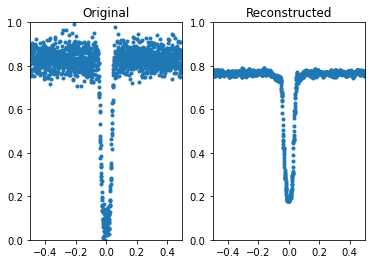

In [46]:
X_example = np.expand_dims(X_test[30].copy(), axis=0)
cond_example = np.expand_dims(cond_test[30].copy(), axis=0)
z_mean, _, _ = encoder_model.predict([X_example, cond_example])
latent_space = z_mean + 0.1 * np.random.normal(size=z_mean.shape)
generated_transit = decoder_model.predict([latent_space, cond_example])
fig, axs = plt.subplots(1, 2)
axs[0].plot(X_example[0,:,0], X_example[0,:,1], ".")
axs[0].set_ylim(0,1)
axs[0].set_xlim(-0.5, 0.5)
axs[0].set_title("Original")
axs[1].plot(X_example[0,:,0], generated_transit[0,:,1], ".")
axs[1].set_ylim(0,1)
axs[1].set_xlim(-0.5, 0.5)
axs[1].set_title("Reconstructed")
plt.show()

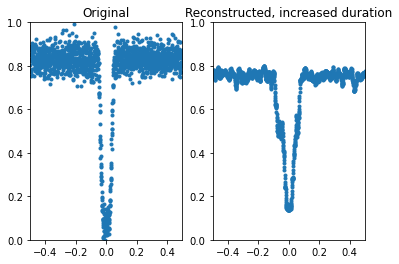

In [28]:
X_example = np.expand_dims(X_test[30].copy(), axis=0)
cond_example = np.expand_dims(cond_test[30].copy(), axis=0)
z_mean, _, _ = encoder_model.predict([X_example, cond_example])
latent_space = z_mean + 0.1 * np.random.normal(size=z_mean.shape)
cond_example[0,1] += 3
generated_transit = decoder_model.predict([latent_space, cond_example])
fig, axs = plt.subplots(1, 2)
axs[0].plot(X_example[0,:,0], X_example[0,:,1], ".")
axs[0].set_ylim(0,1)
axs[0].set_xlim(-0.5, 0.5)
axs[0].set_title("Original")
axs[1].plot(X_example[0,:,0], generated_transit[0,:,1], ".")
axs[1].set_ylim(0,1)
axs[1].set_xlim(-0.5, 0.5)
axs[1].set_title("Reconstructed, increased duration")
plt.show()

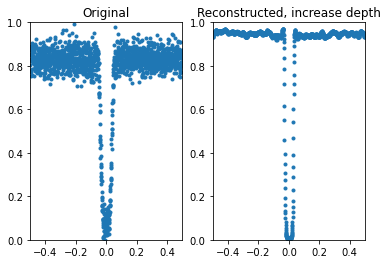

In [29]:
X_example = np.expand_dims(X_test[30].copy(), axis=0)
cond_example = np.expand_dims(cond_test[30].copy(), axis=0)
z_mean, _, _ = encoder_model.predict([X_example, cond_example])
latent_space = z_mean + 0.1 * np.random.normal(size=z_mean.shape)
cond_example[0,0] += 7
generated_transit = decoder_model.predict([latent_space, cond_example])
fig, axs = plt.subplots(1, 2)
axs[0].plot(X_example[0,:,0], X_example[0,:,1], ".")
axs[0].set_ylim(0,1)
axs[0].set_xlim(-0.5, 0.5)
axs[0].set_title("Original")
axs[1].plot(X_example[0,:,0], generated_transit[0,:,1], ".")
axs[1].set_ylim(0,1)
axs[1].set_xlim(-0.5, 0.5)
axs[1].set_title("Reconstructed, increase depth")
plt.show()

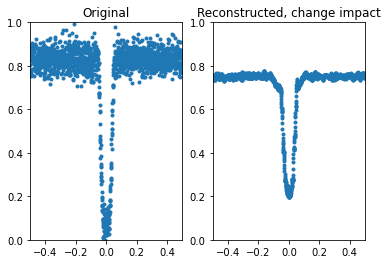

In [47]:
X_example = np.expand_dims(X_test[30].copy(), axis=0)
cond_example = np.expand_dims(cond_test[30].copy(), axis=0)
z_mean, _, _ = encoder_model.predict([X_example, cond_example])
latent_space = z_mean + 0.1 * np.random.normal(size=z_mean.shape)
cond_example[0,2] = 0.5
generated_transit = decoder_model.predict([latent_space, cond_example])
fig, axs = plt.subplots(1, 2)
axs[0].plot(X_example[0,:,0], X_example[0,:,1], ".")
axs[0].set_ylim(0,1)
axs[0].set_xlim(-0.5, 0.5)
axs[0].set_title("Original")
axs[1].plot(X_example[0,:,0], generated_transit[0,:,1], ".")
axs[1].set_ylim(0,1)
axs[1].set_xlim(-0.5, 0.5)
axs[1].set_title("Reconstructed, change impact")
plt.show()

In [40]:
def GenerateTransits(X_test, cond_test, LATENT_SPACE_SIZE, noise_level):
    sample_index = random.sample(range(1, len(X_test)), 15)
    X_samples = X_test[sample_index]
    cond_samples = cond_test[sample_index]
    z_mean, _, _ = encoder_model.predict([X_samples, cond_samples])
    latent_space = z_mean + noise_level * np.random.normal(size=z_mean.shape)
    generated_transit = decoder_model.predict([latent_space, cond_samples])
    
    fig = plt.figure(figsize=(15,10))
    number_of_images = len(generated_transit)
    for i in range(number_of_images):
        ax = fig.add_subplot(3, 5, i+1)
        ax.plot(generated_transit[i][:,1])
    return generated_transit

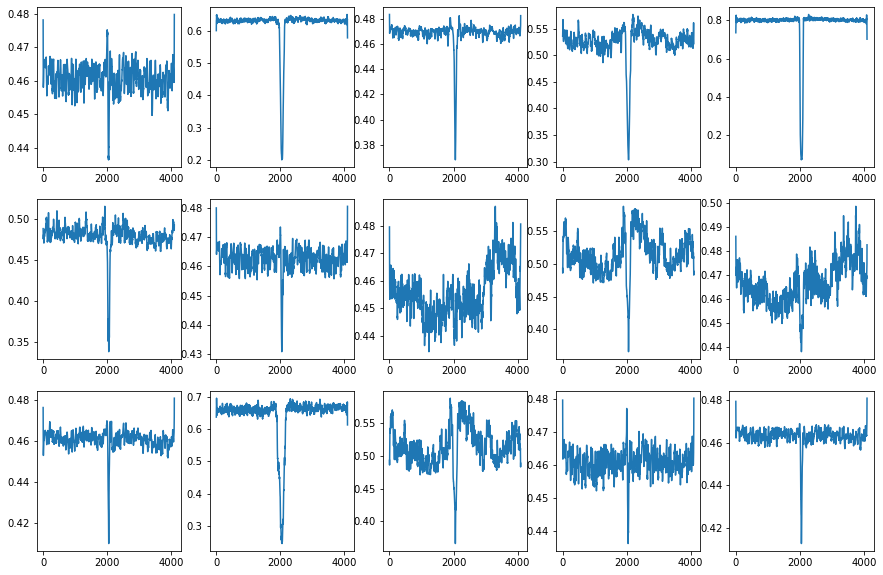

In [44]:
generated_transits = GenerateTransits(X_test, cond_test, LATENT_SPACE_SIZE, noise_level=0.01)